### Use the National Land Cover Database to make roughness maps of Manning's *n*

The friction factor used in hydrodynamics models to calculate bottom stress ${\tau}_b = C_fU|U|$ is related to Manning's *n* as $C_f = gn^2/h^{1/3}$. Including the higher values of $C_f$ usually found on land may improve innundation calculations.

This notebook demonstrates downloading the NLCD, converting to Manning's *n* and interpolating it onto a grid.

The steps are:
1. Import the necessary packages. In particular, a development version of `rasterio` is needed.
2. Get a portion of the NLCD database from Rich Signell's public Amazon S3 bucket.
3. Save it as a `netcdf` file in case you want to mess with it later.
4. Use the NLCD indices as a look-up table (dict) to make an array of Manning's *n*.
5. Interpolate that onto the model grid. (The NLCD data is on an Alber's Equal Area projection).

### Key references

Home for the National Land Cover Database: https://www.mrlc.gov/index.php. You can download the entire dataset (1.1 Gb) here: http://www.landfire.gov/bulk/downloadfile.php?TYPE=nlcd2011&FNAME=nlcd_2011_landcover_2011_edition_2014_10_10.zip

Preferred NLCD 2011 citation: Homer, C.G., Dewitz, J.A., Yang, L., Jin, S., Danielson, P., Xian, G., Coulston, J., Herold, N.D., Wickham, J.D., and Megown, K., 2015, Completion of the 2011 National Land Cover Database for the conterminous United States-Representing a decade of land cover change information. *Photogrammetric Engineering and Remote Sensing*, v. 81, no. 5, p. 345-354 .

Conversion from land classification to roughness:

Mattocks, C., Forbes, C., 2008. A real-time, event-triggered storm surge forecasting system for the state of North Carolina. *Ocean Modelling* 25, 95–119. https://doi.org/10.1016/j.ocemod.2008.06.008.

Mattocks, C., Forbes, C., Ran, L., 2006. *Design and implementation of a real-time storm surge and ﬂood forecasting capability for the State of North Carolina*. UNC–CEP Technical Report, November 30, 2006, 103 pp.

## 1. Import the necessary packages

All of these are in the IOOS3 conda environment, which you can create following Rich Signell's instructions here:
http://ioos.github.io/notebooks_demos/other_resources/

In particular, you need updated versions of rasterio and xarray, installed as follows:
```
conda install -c conda-forge/label/dev   rasterio
conda install -c conda-forge   xarray
```

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.io
from scipy import interpolate
import scipy.ndimage
import xarray as xr
from pyproj import Proj, transform
%matplotlib inline

In [2]:
fname = "https://rsignell.s3.amazonaws.com/NLCD/nlcd_2011_landcover_2011_edition_2014_10_10.tif"
ds = xr.open_rasterio(fname, chunks={'x':256, 'y':256})
ds

<xarray.DataArray (band: 1, y: 104424, x: 161190)>
dask.array<shape=(1, 104424, 161190), dtype=uint8, chunksize=(1, 256, 256)>
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 3.31e+06 3.31e+06 3.31e+06 3.31e+06 3.31e+06 ...
  * x        (x) float64 -2.493e+06 -2.493e+06 -2.493e+06 -2.493e+06 ...
Attributes:
    transform:   (30.0, 0.0, -2493045.0, 0.0, -30.0, 3310005.0, 0.0, 0.0, 1.0)
    crs:         +ellps=GRS80 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +n...
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

## 2. Select a subgrid using lon/lat of upper left corner and xsize, ysize (m)

1890508.8483342826 2218413.1952201454


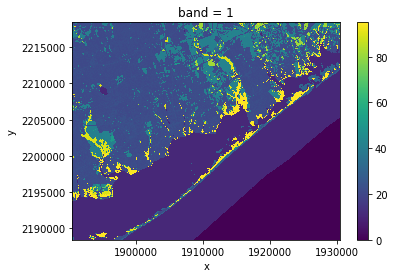

In [3]:
# coordinates for upper left corner of Fire Island grid
ul =[-73.1500,  40.92]

# specify projections
llProj = Proj(init='epsg:4326') # WGS84 lat/lon
aeProj = Proj(ds.crs)
e0,n0 = transform(llProj,aeProj,ul[0],ul[1])
print(e0,n0)

# size of region in meters
xsize, ysize = 40000., 30000.
e1 = e0 + xsize
n1 = n0 - ysize
dss = ds[0,:,:].sel(x=slice(e0,e1), y=slice(n0,n1))
dss.plot.imshow()

## 3. Save the subregion as a `netcdf` file

The header info in the `.nc` file will look like this:

```
netcdf nlcd_subregion {
dimensions:
        y = 1000 ;
        x = 1334 ;
variables:
        int band ;
        double y(y) ;
                y:_FillValue = NaN ;
        double x(x) ;
                x:_FillValue = NaN ;
        ubyte __xarray_dataarray_variable__(y, x) ;
                __xarray_dataarray_variable__:transform = 30., 0., -2493045., 0., -30., 3310005., 0., 0., 1. ;
                __xarray_dataarray_variable__:crs = "+ellps=GRS80 +lat_0=23 +lat_1=29.5 +lat_2=45.5 +lon_0=-96 +no_defs +proj=aea +towgs84=0,0,0,0,0,0,0 +units=m +x_0=0 +y_0=0" ;
                __xarray_dataarray_variable__:res = 30., 30. ;
                __xarray_dataarray_variable__:is_tiled = 1UB ;
                __xarray_dataarray_variable__:nodatavals = NaN ;
                __xarray_dataarray_variable__:coordinates = "band" ;
}
```

In [4]:
dss.to_netcdf('nlcd_subregion.nc')

## 4. Make a dict to convert from NLCD number to Manning's *n* and surface roughness length

### Here is the table from Mattocks and Forbes (2008) showing the classification values

![From Mattocks and Forbes (2008)](./nlcd_to_roughness.png)
    

### Make the look-up table (dict)...use 0.02 (same as open water) for missing values (class 0)

In [5]:
n = {11:0.02, 12:0.10, 21:0.02, 22:0.05, 23:0.10, 24:0.15,\
     31:0.09, 32:0.04, 41:0.10, 42:0.11, 43:0.10, 51:0.04,\
     52:0.05, 71:0.034, 72:0.03, 73:0.027, 74:0.025, 81:0.033,\
     82:0.037, 90:0.10, 91:0.10, 92:0.048, 93:0.10, 94:0.048,\
     95:0.045, 96:0.045, 97:0.045, 98:0.015, 99:0.015,\
     0:0.02} 

print("Manning's n value for class 11: n[11]=",n[11])
# print("Class number at index 150,150: z[150,150]=", z[150,150])
# print("Manning's n value for the class number at index 150,150: n[z[150,150]]=",n[z[150,150]])

#TODO - make similar dicts for roughness and canopy

Manning's n value for class 11: n[11]= 0.02


In [6]:
# There may be a more efficient way to assign a dict to the xarray dataset

# Make an array of NLCD land cover indices from the DataArray
lci = dss.values
lci

array([[24, 23, 24, ..., 52, 52, 21],
       [24, 23, 22, ..., 52, 52, 52],
       [23, 24, 24, ..., 52, 52, 21],
       ..., 
       [11, 11, 11, ...,  0,  0,  0],
       [11, 31, 31, ...,  0,  0,  0],
       [11, 31, 31, ...,  0,  0,  0]], dtype=uint8)

In [7]:
# initialize a float array with same shape as the NLCD array
nmap = 0.0*np.ones_like(lci[:,:])
(ni,nj)=np.shape(lci[:,:])
print('Shapes of new np array and DataArray: ',np.shape(lci[:,:]),np.shape(nmap))
print('Print number of rows, columns: ',ni,nj)

# loop through and assign Manning's n value to array using class look-up table
for i in range(ni):
    for j in range(nj):
        nmap[i,j]=n[lci[i,j]]
print('\nRoughness values:')
nmap

Shapes of new np array and DataArray:  (1000, 1334) (1000, 1334)
Print number of rows, columns:  1000 1334

Roughness values:


array([[ 0.15,  0.1 ,  0.15, ...,  0.05,  0.05,  0.02],
       [ 0.15,  0.1 ,  0.05, ...,  0.05,  0.05,  0.05],
       [ 0.1 ,  0.15,  0.15, ...,  0.05,  0.05,  0.02],
       ..., 
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02,  0.02],
       [ 0.02,  0.09,  0.09, ...,  0.02,  0.02,  0.02],
       [ 0.02,  0.09,  0.09, ...,  0.02,  0.02,  0.02]])

In [8]:
# make same-sized arrays of x and y
x = dss['x'].values
y = dss['y'].values

# the interpolation scheme want ascending values...y starts in the upper left and descends, so flip it...
y = np.flip(y,0)
xx,yy = np.meshgrid(x,y)
print('Shape of xx: ',np.shape(xx))

# ...and flip the data grid too
nmap = np.flipud(nmap)
print('Shape of nmap:',np.shape(nmap))

Shape of xx:  (1000, 1334)
Shape of nmap: (1000, 1334)


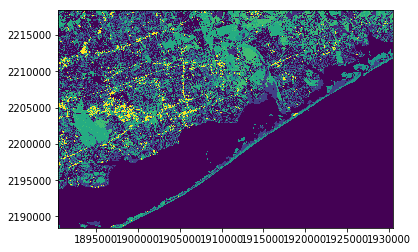

In [9]:
# look at the roughness map
plt.pcolormesh(xx,yy,nmap)

In [10]:
# convert a lat/lon point to Albers and interpolate in grid
lon = -(72+53.7/60.)
lat = 40+43.47/60.
et,nt = transform(llProj,aeProj,lon,lat)

# Both of these whine about the fact that y decreases, rather than increases...so y and nmap have been flipped
f=interpolate.RegularGridInterpolator((y,x), nmap, method='nearest')

# interpolate.interpn((y,x), nmap, np.array((et,nt)),method='nearest')
print('Value at x= ',et,' and y = ',nt,': ',f((nt,et)))

Value at x=  1916462.1488077617  and y =  2202263.646877269 :  0.045


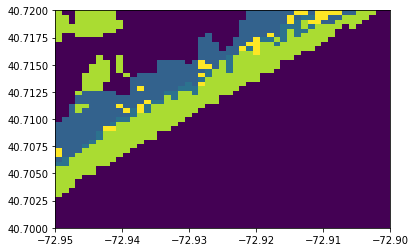

In [11]:
# Make a little lat/lon grid to test interpolation
lons = np.linspace(-72.95,-72.90,50);
lats = np.linspace(40.70,40.72,50);
lon, lat = np.meshgrid(lons, lats)
et,nt = transform(llProj,aeProj,lon,lat)
nmapi = f((nt,et))
# look at the roughness map
plt.pcolormesh(lon,lat,nmapi)